In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
import re
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer as countvec

In [68]:
## importing all csv data
money = pd.read_csv('money_with_tags.csv').drop('Unnamed: 0', axis=1)
tech = pd.read_csv('medium-tech-data.csv').drop('Unnamed: 0', axis=1)
sports = pd.read_csv('medium-sports-data.csv').drop('Unnamed: 0', axis=1)
politics = pd.read_csv('Politics_data_full.csv').drop('Unnamed: 0', axis=1)
tech['type'] = [0]*len(tech)
sports['type'] = [1]*len(sports)
money['type'] = [2]*len(money)
politics['type'] = [3]*len(politics)

In [69]:
# removing columns in politics that are not in tech
for i in politics.columns:
    if i in tech.columns:
        continue
    else:
        politics = politics.drop(i, axis=1)

In [70]:
# removing columns in tech that are not in politics
for i in tech.columns:
    if i in politics.columns:
        continue
    else:
        tech = tech.drop(i, axis=1)

In [71]:
# removing columns in sports that are not in the other tables
for i in sports.columns:
    if i in politics.columns:
        continue
    else:
        sports = sports.drop(i, axis=1)

In [72]:
# removing columns in money that are not in the other tables
for i in money.columns:
    if i in politics.columns:
        continue
    else:
        money = money.drop(i, axis=1)

In [73]:
def convert_to_int(followers):
    if followers[-1]=='K':
        return 1000* float(followers[:-1])
    return int(followers)
def check_if_k(string):
    if ',' in string:
        return False
    if 'fall' in string:
        return False
    if 'Whether' in string:
        return False
    if string[-1]=='K' and string[:-1].isalpha()==False:
        return True
    elif string[-1]!='K' and string.isalpha()==False:
        return True
    return False
sports = sports.loc[sports['claps'].apply(check_if_k)].reset_index(drop=True)

In [74]:
# clean sports table
sports = sports.dropna().reset_index(drop=True)
sports = sports.loc[list(sports['tags'].apply(lambda x: x[0]=='['))].reset_index(drop=True)
sports['followers']=sports['followers'].apply(convert_to_int)
sports['following']=sports['following'].apply(convert_to_int)
sports['claps'] = sports['claps'].apply(convert_to_int)
sports['published'] = pd.to_datetime(sports['published'])

In [75]:
# clean politics table
tech['followers']=tech['followers'].apply(convert_to_int)
tech['following']=tech['following'].apply(convert_to_int)
tech = tech.loc[tech['claps'].apply(check_if_k)].reset_index(drop=True)
tech['claps']=tech['claps'].apply(convert_to_int)
tech['published'] = pd.to_datetime(tech['published'])

In [76]:
# clean politics table
politics = politics[politics.claps != 2020].reset_index(drop=True)

In [77]:
# concat 
c_table = pd.concat([tech,sports,money, politics],sort=False)

In [129]:
#dropping features that don't have any effect on the model
f_table = c_table.drop(['url', 'author', 'published','username'],axis=1).reset_index(drop=True)
f_table = f_table.dropna()

In [130]:
## Convert the tags and text columns to tfidf and add it to table

## The following function converts list of tags to a combined
## string
def tag_words(tags):
    return ' '.join(re.findall("\w+", tags)).lower()
f_table['tags']=f_table['tags'].apply(tag_words)
f_table['text']=f_table['text'].apply(tag_words)
f_table['title']=f_table['title'].apply(tag_words)
#vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 200)
#vector.fit(f_table['text'])
#text_tfidf = vector.transform(f_table['text']).toarray()
#f_table = pd.concat([f_table,pd.DataFrame(text_tfidf, columns=vector.get_feature_names())],axis=1)
#vector.fit(f_table['tags'])
#text_tfidf = vector.transform(f_table['tags']).toarray()
#f_table = pd.concat([f_table,pd.DataFrame(text_tfidf, columns=vector.get_feature_names())],axis=1)

In [131]:
## drop unnecessary columns and split dataset into test, train and validation 
#f_table = f_table.drop(['text','tags'],axis=1)
f_table = f_table.dropna()
X= f_table.drop('type',axis=1)
y= f_table['type'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

## Exploring the data

In [193]:
tech = f_table.loc[f_table['type']==0]
sports = f_table.loc[f_table['type']==1]
money = f_table.loc[f_table['type']==2]
politics = f_table.loc[f_table['type']==3]

### Understanding what words are important in each category 

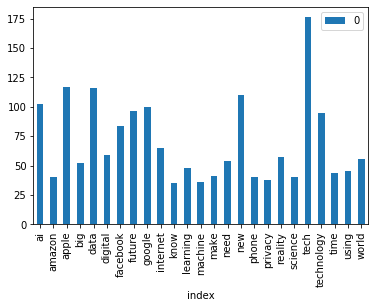

In [220]:
vector = countvec(stop_words = "english", strip_accents = 'ascii', max_features = 25)
pd.DataFrame(pd.DataFrame(vector.fit_transform(tech['title']).toarray(), columns=vector.get_feature_names()).sum(axis=0)).reset_index().plot.bar(x='index',y=0)

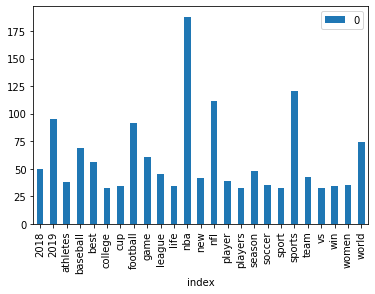

In [221]:
vector = countvec(stop_words = "english", strip_accents = 'ascii', max_features = 25)
pd.DataFrame(pd.DataFrame(vector.fit_transform(sports['title']).toarray(), columns=vector.get_feature_names()).sum(axis=0)).reset_index().plot.bar(x='index',y=0)

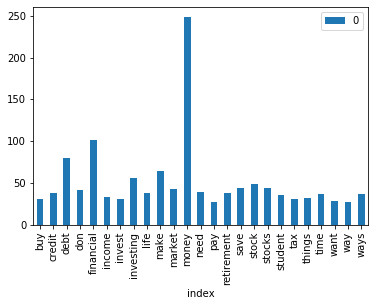

In [222]:
vector = countvec(stop_words = "english", strip_accents = 'ascii', max_features = 25)
pd.DataFrame(pd.DataFrame(vector.fit_transform(money['title']).toarray(), columns=vector.get_feature_names()).sum(axis=0)).reset_index().plot.bar(x='index',y=0)

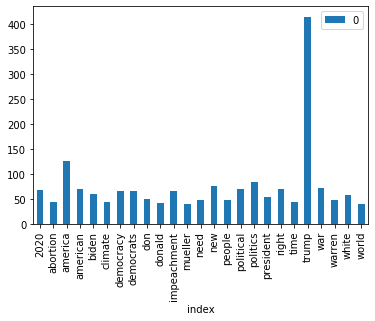

In [223]:
vector = countvec(stop_words = "english", strip_accents = 'ascii', max_features = 25)
pd.DataFrame(pd.DataFrame(vector.fit_transform(politics['title']).toarray(), columns=vector.get_feature_names()).sum(axis=0)).reset_index().plot.bar(x='index',y=0)

## Implementing a Multinomial Naive Bayes Classification Model

In [156]:
lst_model = []
train_accuracy = []
test_accuracy = []

Since the Multinomial Naive Bayes Model works best with text data hence all other features such as followers and following were removed from the feature set. The only features used and worked best with the classifier are <b>text, tag and title</b>. <br>

With stopwords:

In [157]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1])), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,1)), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,1)), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9578
Validation accuracy: 0.9192


In [158]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1])), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,2)), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,2)), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9565
Validation accuracy: 0.8930


Without stopwords:

In [159]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1]),stop_words='english'), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,1),stop_words='english'), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,1),stop_words='english'), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9664
Validation accuracy: 0.9352


In [160]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1]),stop_words='english'), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,2),stop_words='english'), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,2),stop_words='english'), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9731
Validation accuracy: 0.9196


In [173]:
train_val = []
for i in range(len(train_accuracy)):
    temp = []
    if i==0 or i==1:
        temp.append('include stop-words')
    if i==2 or i==3:
        temp.append('remove stop-words')
    if i==0 or i==2:
        temp.append('unigrams')
    if i==1 or i==3:
        temp.append('unigrams and bigrams')
    temp.append(train_accuracy[i])
    temp.append(test_accuracy[i])
    train_val.append(temp)
compiled_models = pd.DataFrame(train_val, columns=['Stop-Words','Unigrams/Bigrams','Train Accuracy','Validation Accuracy'])

The model was further optimised by playing with ngrams when converting text, tag and title to tfidf.<br>
The best combination of ngrams was unigrams for tags, text and title. Converting the tfidf to either unigrams or bigrams for any of the features resulted in the training data to be overfit, hence, the validation score would drop.

In [174]:
compiled_models

,Stop-Words,Unigrams/Bigrams,Train Accuracy,Validation Accuracy
0,include stop-words,unigrams,0.957761,0.919229
1,include stop-words,unigrams and bigrams,0.956531,0.892989
2,remove stop-words,unigrams,0.966373,0.935219
3,remove stop-words,unigrams and bigrams,0.973139,0.919639


In [186]:
y_test_pred = lst_model[2].predict(X_test)
print('Test accuracy: %.4f' % accuracy_score(y_test_pred, y_test))

Test accuracy: 0.9381


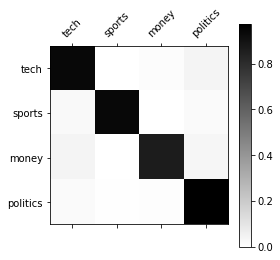

In [189]:
C = confusion_matrix(y_test, y_test_pred)
C = C / C.astype(np.float).sum(axis=1)
classes = ['tech', 'sports','money','politics']
df_confusion = pd.DataFrame(C, columns=classes, index=classes)
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

_____________________________
<b>##Include everything above on the presentation. The Regression model was a bust :((<b>

## Creating a Poisson Regression Model

In [81]:
expr = """claps ~ followers  + following"""
for i in f_table.columns:
    if i not in expr:
        expr += (""" + """+i)
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [83]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4939
Model:                            GLM   Df Residuals:                     4540
Model Family:                 Poisson   Df Model:                          398
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2164e+05
Date:                Wed, 04 Dec 2019   Deviance:                   1.8149e+06
Time:                        12:07:14   Pearson chi2:                 5.26e+06
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.009e-11   1.37e-12     14.689      0.0

In [84]:
poisson_predictions = poisson_training_results.predict(X_train)
#.summary_frame() returns a pandas DataFrame
#predictions_summary_frame = poisson_predictions.summary_frame()
#print(predictions_summary_frame)

In [85]:
print(poisson_training_results.mu)
print(len(poisson_training_results.mu))

[370.1079497  117.51776072   4.86315552 ...  10.41905201  15.3677639
 107.10964222]
4939


In [86]:
from sklearn.metrics import mean_squared_error
mean_squared_error(poisson_predictions, y_train)
#poisson_predictions.toarray()

253961.3428946017

## Creating a Negative Binomial Model

In [87]:
df_train = pd.DataFrame(X_train,columns=f_table.drop('claps',axis=1).columns)
df_train['lambda']=poisson_training_results.mu
df_train['claps']=y_train
df_train['aux_ols_dep'] = df_train.apply(lambda x: ((x['claps'] - x['lambda'])**2 - x['claps']) / x['lambda'], axis=1)
ols_expr = """aux_ols_dep ~ Q("lambda") - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [88]:
print(aux_olsr_results.params)

Q("lambda")    0.218962
dtype: float64


In [89]:
aux_olsr_results.tvalues

Q("lambda")    2.291848
dtype: float64

In [90]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [91]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4939
Model:                            GLM   Df Residuals:                     4540
Model Family:        NegativeBinomial   Df Model:                          398
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54936.
Date:                Wed, 04 Dec 2019   Deviance:                       67746.
Time:                        12:07:58   Pearson chi2:                 7.32e+05
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.307e-12   9.07e-12      0.695      0.4

In [92]:
nb2_predictions = nb2_training_results.predict(X_train)
mean_squared_error(nb2_predictions, y_train)

3936932.8664925788